# Implement all the necessary imports

In [262]:
# Gute Fragestellung für datascience Projekt (Sportify)
# Gibt es einen Zusammenhang zwischen eigenen Musikgeschmack und der Geschmack der anderen?

# Importieren der benötigten Bibliotheken
import sys
import os as os
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import spotipy
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm_notebook
from matplotlib import cm
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples
from sklearn.cluster import DBSCAN
from sklearn.metrics import homogeneity_completeness_v_measure
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering



# Preperation of the data

In [263]:
CLIENT_ID = "082b3dd7a97642d49b60a647673caa75"
CLIENT_SECRET = "276e4715f8a14a34a7622c0105a8588c"
USERSANGEETHS = "qme120m1x3bg2wrtw3haiiyrb"
USERSTIAFEN = "stiafen"

client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) #spotify object to access API

In [264]:
# get all playlists of a user
def get_playlists(user):
    playlists = sp.user_playlists(user)
    playlist_ids = []
    while playlists:
        for i, playlist in enumerate(playlists['items']):
            playlist_ids.append(playlist['id'])
        if playlists['next']:
            playlists = sp.next(playlists)
        else:
            playlists = None
    return playlist_ids

In [265]:
playlistsSangeeths = get_playlists(USERSANGEETHS)
playlistsTiafen = get_playlists(USERSTIAFEN)

# get the name of the playlists, will later be used to print all available playlists for a user
def get_playlist_name(user, playlist_id):
    playlist = sp.user_playlist(user, playlist_id)
    return playlist['name'], playlist['id']


In [266]:
#Funktion welche mittels user und playlist ID alle Tracks für eine Playlist ausgibt
def get_playlist_tracks(user, playlist_id):
    results = sp.user_playlist_tracks(user, playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    df = pd.DataFrame(tracks)
    df = df['track']
    df = df.apply(pd.Series)
    return df


In [267]:
#Funktion welche mittels user und playlist ID alle Tracks für eine Playlist ausgibt
def get_playlist_tracks_artists(user, playlist_id):
    results = sp.user_playlist_tracks(user, playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [268]:
def get_audio_features(user, tracklist):
    #Dateinamen festlegen, falls vorhanden werden diese Daten ausgewertet statt Abfragen per API zu machen

    if not os.path.isfile("audiodata.csv"):
        features = []
        #Extract Audio Features
        for uri in tracklist['uri']:

            features = features+sp.audio_features(uri)

        #Dataframe generieren

        audioFeatures = pd.DataFrame(features)
        #Für den Datensatz mit welchem wir die Modelle testen möchten brauchen wir keinen user eintrag, da dieser ja predicted werden soll
        if not user == "validation":
            audioFeatures['user'] = user
        #Daten exportieren

        return audioFeatures

    else:
        #Falls vorhanden lese csv als Dataframe ein, wobei userspezifisch
        audioFeatures = pd.read_csv("audiodata.csv")
        audioFeatures = audioFeatures.loc[audioFeatures['user'] == user]
        return audioFeatures

Um nun die ID der playlist zu erhalten, in welcher wir unsere Lieblingssongs gespeichert haben nutzen wir die zuvor definierte Funktion `get_playlist_name` welche über das Resultat der Funktion `get_playlists` für den jeweiligen Benutzer läuft.
Um die Übersicht zu behalten haben wir unsere Playlists *Fav Songs "NAME"* genannt

In [269]:
for playlist in playlistsSangeeths:
    print(get_playlist_name(USERSANGEETHS, playlist))

for playlist in playlistsTiafen:
    print(get_playlist_name(USERSTIAFEN, playlist))

('Testo pur🏋🏽', '7o70luarSZS5DHoODMH51U')
('Fav Songs Sangeeths', '2E7GAf1h3F19ezc18w1NpZ')
('Tamil Vibes', '64Lq6W07GIOs087K88iOzT')
('Arabic  Vibes', '1Rr83zHLDULxQDbC9taydm')
('Albanien Vibes', '6jyy1HUool6rj0xWLVsAPC')
('UK DRILL ', '5ycwKESGY1Z71ftYWmTVJs')
('Baba Vibes', '67a5HCEjwm4aXvjPVoxoAX')
('DataScience Validation', '1k287mopfeltXpHYYab7di')
('Fav Songs Stiafen', '0ekbyk9EKkCf4MBjrQoM2D')
('Favorite Songs', '4DeCJm3aeeb0TTdthf8MGY')
('Caterpillar (feat. Eminem & King Green)', '1JKSl9B6hJNCGFs9FdOq8I')
('Meine Playlist Nr.\xa034', '3uBDJVShkGJKFxPNnjC7IL')
('Dein Mixtape\xa06 - ZUSAMMENGESTELLT FÜR STIAFEN:21.06.19', '48I13UCIzloZpyRE23zwIa')
('Mixtape 3', '2jnqcj5CxaBLHjzVafdmce')
('Oldschool', '4RjDNPzba04zlAan0a4bTE')


# Datensatz laden, filtern und verstehen
Nun da wir die Playlist ID haben können wir die Tracks aus unseren Fav Songs Playlists auslesen und mittels unserer Funktion die audio Features extrahieren.
Zuerst schreiben wir also alle Tracks mit deren Informationen in eine Liste `tracksSangeeths` und `tracksStiafen`

In [270]:
#Variablen für Playlists Sangeeths und Stiafen
favoritplaylistSangeeths = "2E7GAf1h3F19ezc18w1NpZ"
favoritplaylistStiafen = "0ekbyk9EKkCf4MBjrQoM2D"
#In dieser Playlist haben wir Tracks welche wir von unseren ML modellen predicten lassen wollen
validationPlaylist = '1k287mopfeltXpHYYab7di'

# Für Beide User wird eine Liste mit den Trackinfos erstellt
tracksSangeeths = get_playlist_tracks(USERSANGEETHS, favoritplaylistSangeeths)
tracksStiafen = get_playlist_tracks(USERSTIAFEN, favoritplaylistStiafen)

Nun holen wir alle Audio features mit unserer Methode und speichern diese in dem Dataframe *rawAudioFeaturesTotal*.

In [271]:
audioFeaturesStiafen = get_audio_features("Stiafen", tracksStiafen)
audioFeaturesSangeeths = get_audio_features("Sangeeths", tracksSangeeths)

Falls die Datei *rawdata.csv* bereits angelegt wurde, werden die Daten daraus eingelesen

In [272]:

#Um über das Gesamtbild der Daten eine aussage machen zu können nehmen wir beide Dataframes in eines
rawAudioFeaturesTotal = audioFeaturesStiafen.append(audioFeaturesSangeeths)
if not os.path.isfile("audiodata.csv"):
    rawAudioFeaturesTotal.to_csv("audiodata.csv")


C:\Users\Startklar\AppData\Local\Temp\ipykernel_3628\2950041054.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rawAudioFeaturesTotal = audioFeaturesStiafen.append(audioFeaturesSangeeths)


Wir säubern nun noch die Rohdaten ein wenig, das gleiche machen wir mit den Validierungsdatensatz

In [273]:
#Säubere Rohdaten
if "Unnamed: 0" in rawAudioFeaturesTotal:
    rawAudioFeaturesTotal.drop("Unnamed: 0", axis=1, inplace=True)
rawAudioFeaturesTotal.drop("analysis_url", axis=1, inplace=True)
rawAudioFeaturesTotal.drop("id", axis=1, inplace=True)
rawAudioFeaturesTotal.drop("uri", axis=1, inplace=True)
rawAudioFeaturesTotal.drop("type", axis=1, inplace=True)
rawAudioFeaturesTotal.drop("track_href", axis=1, inplace=True)

Wie wir nun sehen sind viele der Spalten für unser Modell nicht von Bedeutung, da es ausschliesslich *danceability* und *energy* als Features benötigt. Im Dataframe welchen wir für unser Unsupervised Machine Learning einsetzen können wir daher alle ausser diesen Zwei Spalten entfernen

In [274]:
#Hauptdatensatz
audioFeaturesTotal = rawAudioFeaturesTotal.copy()
audioFeaturesTotal.drop("key", axis=1, inplace=True)
audioFeaturesTotal.drop("duration_ms", axis=1, inplace=True)
audioFeaturesTotal.drop("time_signature", axis=1, inplace=True)
audioFeaturesTotal.drop("user", axis=1, inplace=True)
audioFeaturesTotal.drop("mode", axis=1, inplace=True)
audioFeaturesTotal.drop("loudness", axis=1, inplace=True)
audioFeaturesTotal.drop("speechiness", axis=1, inplace=True)
audioFeaturesTotal.drop("acousticness", axis=1, inplace=True)
audioFeaturesTotal.drop("instrumentalness", axis=1, inplace=True)
audioFeaturesTotal.drop("liveness", axis=1, inplace=True)
audioFeaturesTotal.drop("valence", axis=1, inplace=True)
audioFeaturesTotal.drop("tempo", axis=1, inplace=True)

Nun verschaffen wir uns einen überblick wie die Daten aussehen

In [275]:
audioFeaturesTotal.describe()

,danceability,energy
count,1450.000000,1450.000000
mean,0.526701,0.405721
std,0.242342,0.319077
min,0.060600,0.000962
25%,0.309250,0.055800
50%,0.545500,0.488000
75%,0.752750,0.700000
max,0.962000,0.986000


In [276]:
audioFeaturesTotal.head()

,danceability,energy
0,0.0614,0.05800
1,0.2990,0.00626
2,0.0877,0.07630
3,0.1760,0.05340
4,0.4280,0.00300


In [277]:
audioFeaturesTotal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1449
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   danceability  1450 non-null   float64
 1   energy        1450 non-null   float64
dtypes: float64(2)
memory usage: 34.0 KB


# Data Quality Assesment
Im Data Quality Assesment schauen wir uns noch Nullwerte und die Min, Max Werte der Spalten an

In [278]:
audioFeaturesTotal.isnull().sum()

danceability    0
energy          0
dtype: int64

Um die Min Max Werte der Spalten zu erhalten nutzen wir nochmals die describe Methode. Die Werte sehen realistisch aus

In [279]:
audioFeaturesTotal.describe()

,danceability,energy
count,1450.000000,1450.000000
mean,0.526701,0.405721
std,0.242342,0.319077
min,0.060600,0.000962
25%,0.309250,0.055800
50%,0.545500,0.488000
75%,0.752750,0.700000
max,0.962000,0.986000


# Data Preprocessing
Um die Datenstandardisierung durchzuführen nutzen wir keinen Standard Scaler, da die Daten für Danceability und Energy im gleichen Wertebereich von 0-1 befinden

In [280]:
#Hauptdatensatz
X = audioFeaturesTotal

# Datenvisualisierungen
Da wir mit mehren Modellen arbeiten wollen, haben wir einerseits einen Countplot und einen Scatterplot eingesetzt

Im untenstehenden Countplot wollten wir sicherstellen, das von beiden Personen etwa die gleiche Menge an Daten verfügbar ist.

<AxesSubplot:xlabel='user', ylabel='count'>

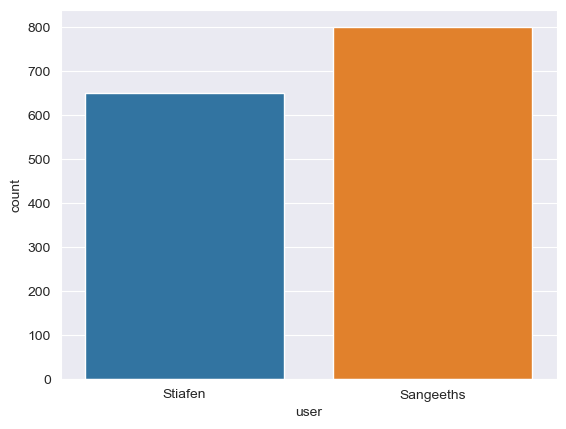

In [281]:
sns.countplot(x = rawAudioFeaturesTotal["user"])

Die Untenstehende Grafik zeigt für die von der Aufgabenstellung gegebenen Features eine klare Clusterbildung für die beiden Personen

<AxesSubplot:xlabel='energy', ylabel='danceability'>

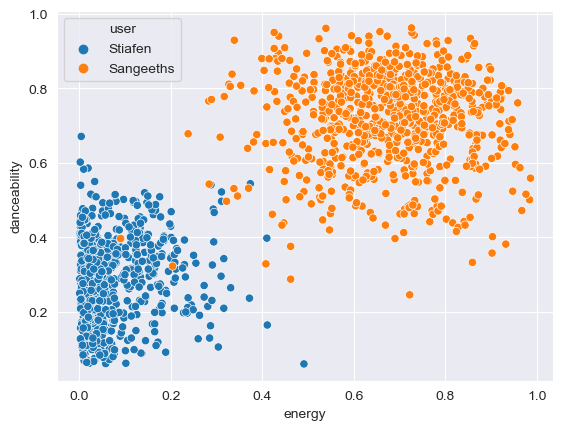

In [282]:
sns.scatterplot(data=rawAudioFeaturesTotal, x="energy", y="danceability", hue="user")

# Kmeans

## Kmeans preparation

In [283]:
inertias = []
K = range(1,10)
for k in tqdm_notebook(K):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    inertias.append(kmeanModel.inertia_)

C:\Users\Startklar\AppData\Local\Temp\ipykernel_3628\1703894294.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(K):


  0%|          | 0/9 [00:00<?, ?it/s]

C:\Users\Startklar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


## Elbow method

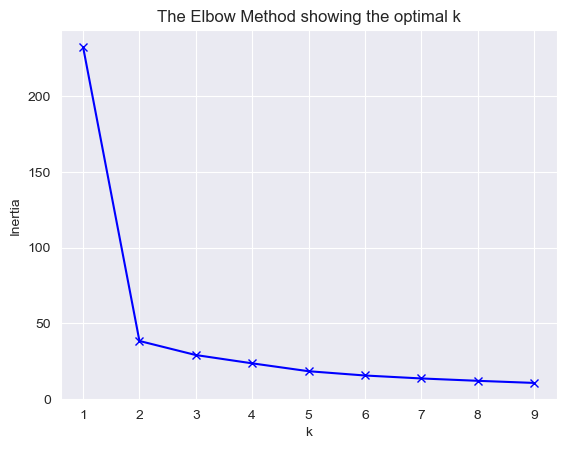

In [284]:
# Plot the elbow
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')

plt.plot(K, inertias, 'bx-')

## Silhouette score method

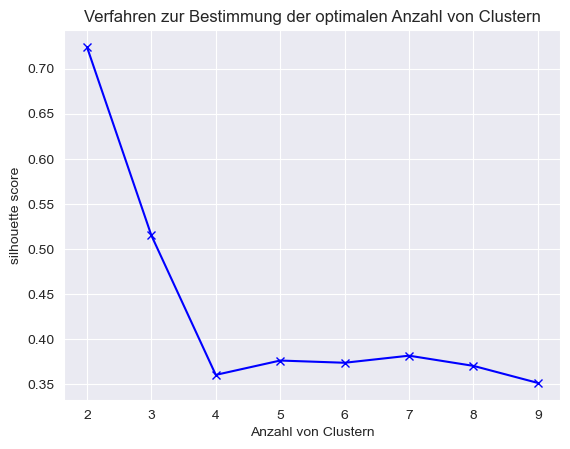

In [285]:
k_values = range(2, 10)
scores = []

for k in k_values:

  model = KMeans(n_clusters=k)

  model.fit(X)
  # silhouette score für das Modell berechnen
  score = silhouette_score(X, model.labels_)
  scores.append(score)

# Plot der silhouette scores gegenüber der Anzahl von Clustern erstellen
plt.plot(k_values, scores, 'bx-')
plt.xlabel('Anzahl von Clustern')
plt.ylabel('silhouette score')
plt.title('Verfahren zur Bestimmung der optimalen Anzahl von Clustern')
plt.show()

## Silhouette score method with plot

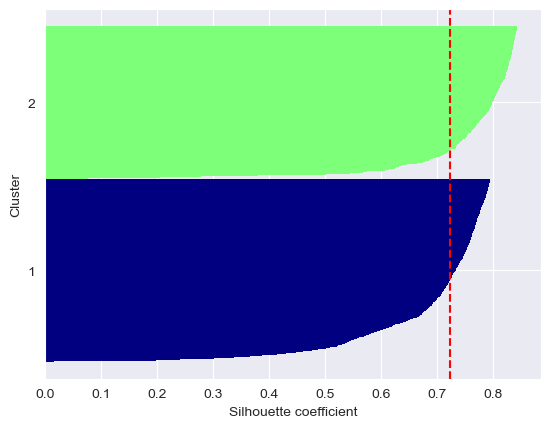

For n_clusters = 2 The average silhouette_score is : 0.7239446390145621


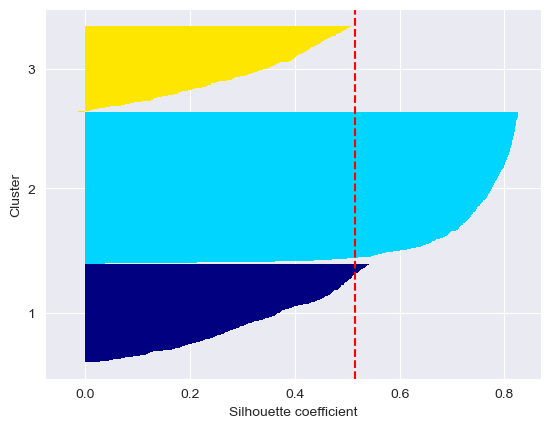

For n_clusters = 3 The average silhouette_score is : 0.5151210809907503


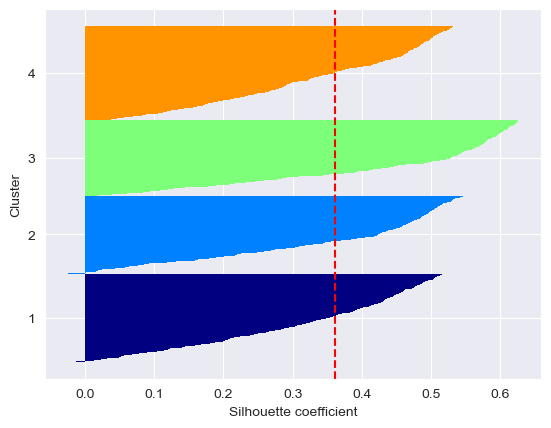

For n_clusters = 4 The average silhouette_score is : 0.36089461153460733


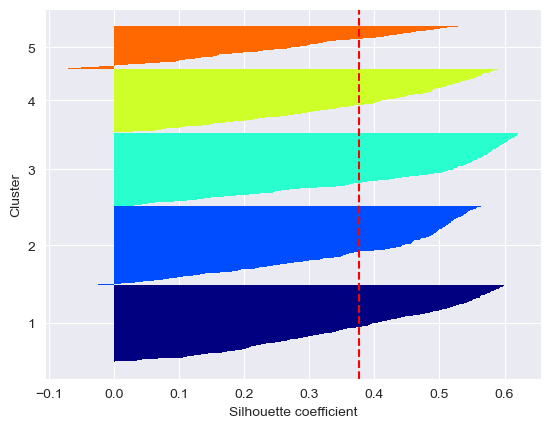

For n_clusters = 5 The average silhouette_score is : 0.3762417625518418


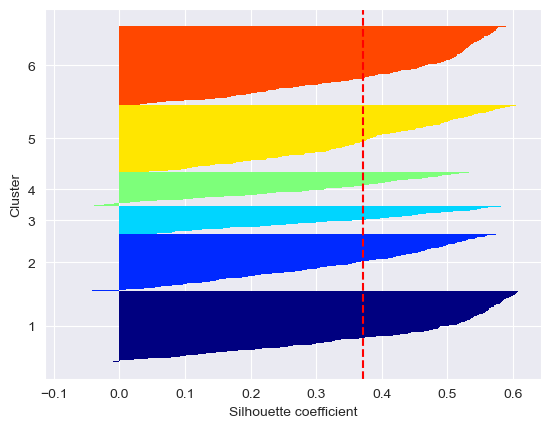

For n_clusters = 6 The average silhouette_score is : 0.3713103851361829


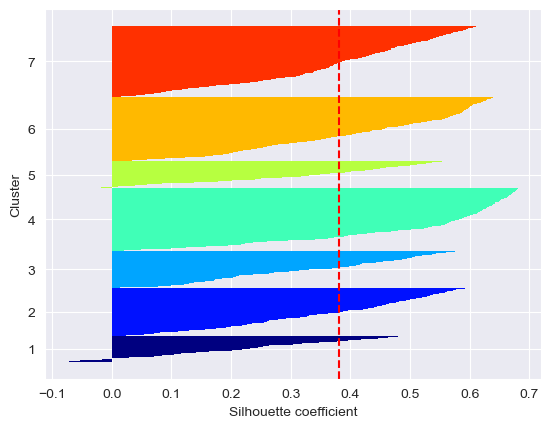

For n_clusters = 7 The average silhouette_score is : 0.3804684631300318


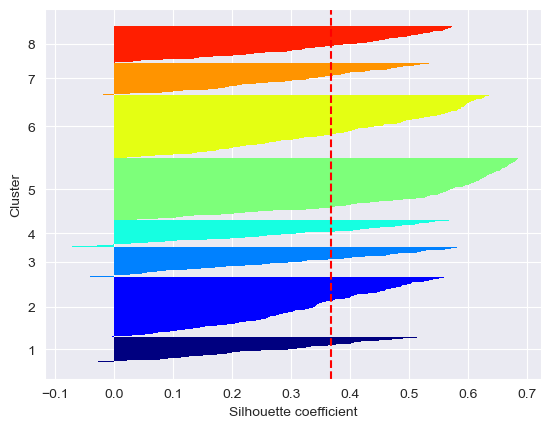

For n_clusters = 8 The average silhouette_score is : 0.37013109723762394


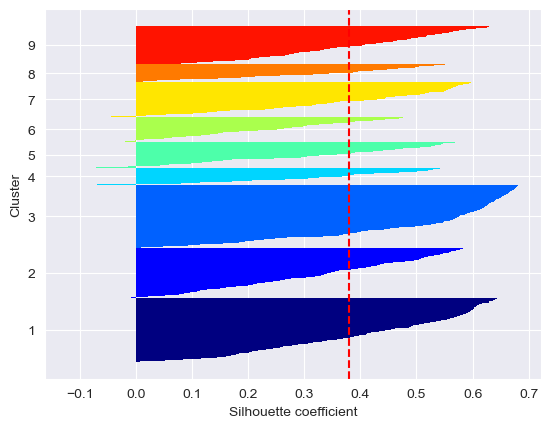

For n_clusters = 9 The average silhouette_score is : 0.3812001772806597


In [286]:
# Anzahl der Cluster festlegen mit shilouette plot_silhouette
def plot_silhouette(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X)
    labels = kmeans.labels_
    silhouette_vals = silhouette_samples(X, labels)
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(np.unique(labels)):
        c_silhouette_vals = silhouette_vals[labels == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, np.unique(labels) + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.show()
    
for n in range(2,10):
    plot_silhouette(X, n)
    clusterer = KMeans(n_clusters=n, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n,
    "The average silhouette_score is :", silhouette_avg)
    

## Kmeans with 2 clusters fit to the data

In [287]:
# fit model with method
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

KMeans(n_clusters=2)

## Kmeans prediction

C:\Users\Startklar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Startklar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Kmeans predictions für 0(Sangeeth) und 1(Stiafen) mit ClusterCentres')]

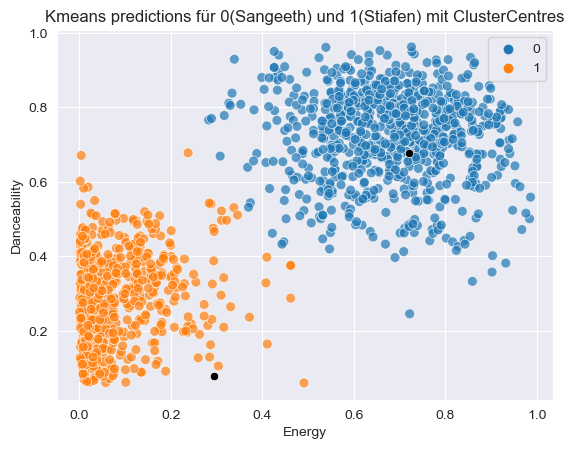

In [288]:
# Using the predict method of KMeans to predict 2 clusters using the sample data
from sklearn import (manifold, datasets)
features = ["energy", "danceability"]

predicted = kmeans.predict(X)
df_X_scaled = pd.DataFrame(X, columns=features)
df_X_scaled.columns = ["Energy", "Danceability"]

# scatter plot with predictions
#Hue according to predicted Cluster (0 being Sangeeth, 1 being Stiafen)
sns.scatterplot(df_X_scaled["Energy"], df_X_scaled["Danceability"], hue=predicted , s=50, cmap='viridis', alpha=0.7)
plt.xlabel("Energy")
plt.ylabel("Danceability")


centers = kmeans.cluster_centers_
# plot centers
sns.scatterplot(centers[:, 0], centers[:, 1], color="black").set(title="Kmeans predictions für 0(Sangeeth) und 1(Stiafen) mit ClusterCentres")


<AxesSubplot:xlabel='energy', ylabel='danceability'>

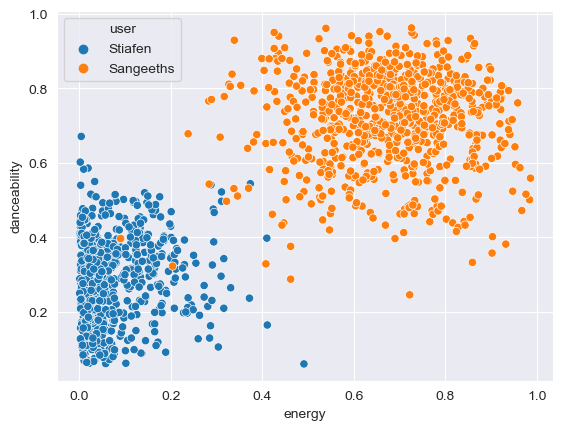

In [289]:
sns.scatterplot(x='energy', y='danceability', hue=rawAudioFeaturesTotal["user"], data=rawAudioFeaturesTotal)

In [290]:
#Check the cross tabulation
matrix = pd.DataFrame({'labels': predicted, 'user': rawAudioFeaturesTotal["user"]})
ct = pd.crosstab(matrix['labels'], matrix['user'])
ct

user,Sangeeths,Stiafen
labels,,
0,788,1
1,11,650


In [291]:
metrics.silhouette_score(X, predicted, metric='euclidean')

0.7239446390145621

# DBSCAN

## DBSCAN preparation

In [292]:
# drop Species (target) from train data
# just take the columns we want energy,daceability, user
data = rawAudioFeaturesTotal[['energy', 'danceability', 'user']]

# get species for validation
y = rawAudioFeaturesTotal['user']
users = {'Sangeeths': 0, 'Stiafen': 1}
y = [users[item] for item in y]
y = np.array(y)

## DBSCAN fit to the data

In [293]:
dbscan = DBSCAN(eps = 0.15, min_samples=38)
dbclusters = dbscan.fit_predict(X)
homogeneity_completeness_v_measure(dbclusters, y)


(0.9235976718455154, 0.9384447590481629, 0.9309620234556295)

## DBSCAN prediction

[Text(0.5, 1.0, 'DBSCAN predictions für -1(Outliers), 0(Stiafen) und 1(Sangeeth)')]

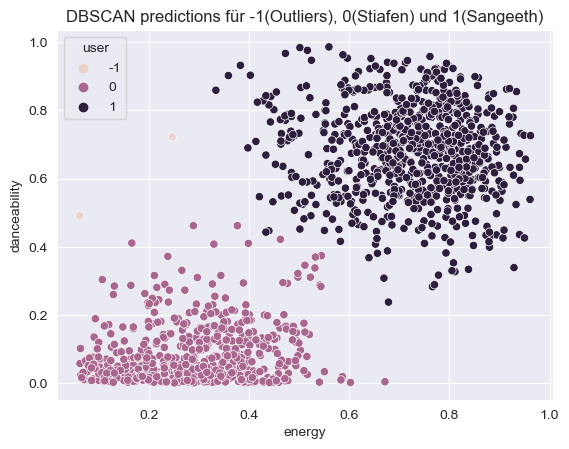

In [294]:
# create DataFrames from data
df_dbclusters = pd.DataFrame(dbclusters)
df_X = pd.DataFrame(X)

# add column names
df_dbclusters.columns = ['user']
df_X.columns = features

# concat both dataframes
df_predicted = pd.DataFrame(pd.concat([df_X, df_dbclusters], axis="columns")).reindex()
# scatter plot, user -1 is outliers, 0 is Stiafen and 1 is Sangeeth
sns.scatterplot(x='energy', y='danceability', hue = 'user', data = df_predicted, legend = True).set(title="DBSCAN predictions für -1(Outliers), 0(Stiafen) und 1(Sangeeth)")


Man sieht im Untenstehenden Countplot, das wenige Punkte als Outliers (-1) markiert wurden

C:\Users\Startklar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='user', ylabel='count'>

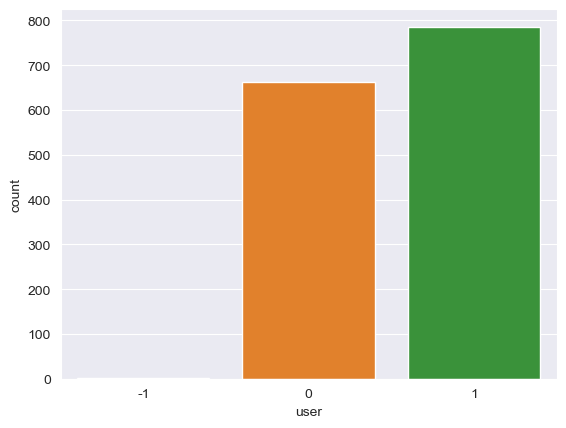

In [295]:
sns.countplot(df_predicted['user'])

## DBSCAN Hyperparameter tuning

In [296]:
#hyperparameter tuning
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
range_min = [x for x in range(2, 51, 1)]
range_eps = [x / 100.0 for x in range(1, 51, 1)] + [y / 10.0 for y in range(1, 51, 1)] + [round(z, 2) for z in np.arange(1.10, 1.31, 0.01)]
dic = {}
for m in range_min:

    for e in range_eps:

        model_1 = DBSCAN(eps = e, min_samples = m).fit(df_X)

        core_samples_mask = np.zeros_like(model_1.labels_, dtype = bool)

        core_samples_mask[model_1.core_sample_indices_] = True

        labels = model_1.labels_

        if len( set(labels) ) > 1:

            silhouette_Avg = silhouette_score(df_X, labels)

            if silhouette_Avg > 0:

                dic[str(m) + " - " + str(e)] = silhouette_Avg

                print("min-sample value is: " + str(m) + " eps value is: " + str(e) , "The avearge silhouette_score is :",silhouette_Avg)
 
max_key = max(dic, key = dic.get)
print("parameter values are: ", max_key)
print("maximum silhouette score value is: ", dic[max_key])

min-sample value is: 2 eps value is: 0.04 The avearge silhouette_score is : 0.31545111978397
min-sample value is: 2 eps value is: 0.05 The avearge silhouette_score is : 0.4013071045749442
min-sample value is: 2 eps value is: 0.06 The avearge silhouette_score is : 0.5141416234157333
min-sample value is: 2 eps value is: 0.07 The avearge silhouette_score is : 0.6137039535248775
min-sample value is: 2 eps value is: 0.08 The avearge silhouette_score is : 0.13424656920415434
min-sample value is: 2 eps value is: 0.09 The avearge silhouette_score is : 0.17306415467870478
min-sample value is: 2 eps value is: 0.1 The avearge silhouette_score is : 0.17306415467870478
min-sample value is: 2 eps value is: 0.11 The avearge silhouette_score is : 0.17306415467870478
min-sample value is: 2 eps value is: 0.12 The avearge silhouette_score is : 0.17306415467870478
min-sample value is: 2 eps value is: 0.13 The avearge silhouette_score is : 0.17306415467870478
min-sample value is: 2 eps value is: 0.14 The a

# Agglomerative Hierarchical Clustering

In [297]:
#implement agglomerative hierarchical clustering
agg = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
aggclusters = agg.fit_predict(X)
homogeneity_completeness_v_measure(aggclusters, y)

(0.935930802260624, 0.9353424055069709, 0.935636511377065)

## Predictions of the model

[Text(0.5, 1.0, 'Aggl. Hierar. Clustering predictions für 0(Sangeeth) und 1(Stiafen)')]

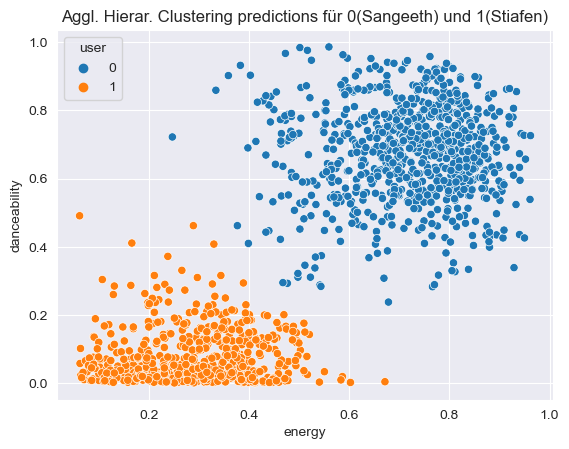

In [298]:
# create DataFrames from data
df_aggclusters = pd.DataFrame(aggclusters)
df_X = pd.DataFrame(X)

# add column names
df_aggclusters.columns = ['user']
df_X.columns = features

# concat both dataframes
df_predicted = pd.DataFrame(pd.concat([df_X, df_aggclusters], axis="columns")).reindex()
# scatter plot
sns.scatterplot(x='energy', y='danceability', hue = 'user', data = df_predicted, legend = True).set(title="Aggl. Hierar. Clustering predictions für 0(Sangeeth) und 1(Stiafen)")


## Countplot Resultat for Agglomerative Hierarchical Clustering

C:\Users\Startklar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='user', ylabel='count'>

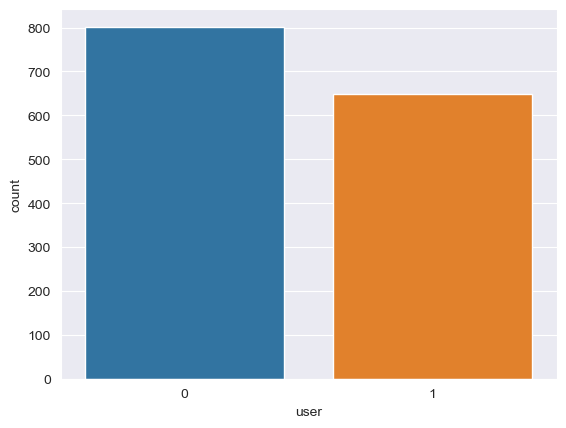

In [299]:
sns.countplot(df_predicted['user'])

## Hyperparameter tuning for Agglomerative Hierarchical Clustering

In [300]:
#hyperparameter tuning with agglomerative clustering correct parameters
range_n_clusters = [x for x in range(2, 51, 1)]
range_linkage = ['ward', 'complete', 'average', 'single']
range_affinity = ['euclidean']
dic = {}
for n in range_n_clusters:
    for l in range_linkage:
        for a in range_affinity:
            clusterer = AgglomerativeClustering(n_clusters=n, linkage=l, affinity=a)
            cluster_labels = clusterer.fit_predict(X)
            silhouette_avg = silhouette_score(X, cluster_labels)
            if silhouette_avg > 0:
                dic[str(n) + " - " + str(l) + " - " + str(a)] = silhouette_avg
                print("For n_clusters =", n, "linkage =", l, "affinity =", a, "The average silhouette_score is :", silhouette_avg)
max_key = max(dic, key = dic.get)
print("parameter value is: ", max_key)
print("maximum silhouette score value is: ", dic[max_key])

For n_clusters = 2 linkage = ward affinity = euclidean The average silhouette_score is : 0.7208854312552017
For n_clusters = 2 linkage = complete affinity = euclidean The average silhouette_score is : 0.6567440353338101
For n_clusters = 2 linkage = average affinity = euclidean The average silhouette_score is : 0.7202465855939314
For n_clusters = 2 linkage = single affinity = euclidean The average silhouette_score is : 0.1364390567023531
For n_clusters = 3 linkage = ward affinity = euclidean The average silhouette_score is : 0.5127643597985848
For n_clusters = 3 linkage = complete affinity = euclidean The average silhouette_score is : 0.5074867148668376
For n_clusters = 3 linkage = average affinity = euclidean The average silhouette_score is : 0.5639856608178632
For n_clusters = 3 linkage = single affinity = euclidean The average silhouette_score is : 0.022168796905162887
For n_clusters = 4 linkage = ward affinity = euclidean The average silhouette_score is : 0.34417462518524183
For n_c